In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Kernel:
    def kernel(self, a, b):
        norm = np.linalg.norm(a - b)
        term = (norm * norm) / (2 * self.sigma * self.sigma)
        return np.exp(-1 * term)

In [196]:
class QKRLS_MSE(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        reg_param=0.1,
        sigma=1,
        min_distance = 1
    ):
        self.reg_param = reg_param
        self.sigma = sigma
        self.Q = np.array(
            [1 / (reg_param + self.kernel(first_input, first_input))])
        
        self.weights = np.array([self.Q * first_output])
        self.inputs = [first_input]
        self.min_distance = min_distance
        
    def predict(self, new_input):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(1, len(self.inputs))
        return h.dot(self.weights)

    def update(self, new_input, expected):
        
        current_dist = 1e10
        current_index = None
        for i in range(0, len(self.inputs)):
            distance = np.linalg.norm(new_input - self.inputs[i])
            if distance < self.min_distance and distance < current_dist:
                current_dist = distance
                current_index = i
                #print(current_index)
        if current_index is not None:
            #pass
            
            h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
            ]).reshape(len(self.inputs), 1)
            ht = h.T
# #             print(self.Q.shape)
# #             print(h.shape)
#             z = self.Q.dot(h)
#             zt = z.T
#             r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
#             Q_size = len(z) 
#             new_Q = np.zeros((Q_size, Q_size))
# #             new_Q[0:Q_size , 0:Q_size ] = self.Q * r + z.dot(zt)
# #             new_Q[0:Q_size , Q_size :Q_size-1] = -z
# #             new_Q[Q_size :Q_size-1, 0:Q_size] = -zt
# #             new_Q[Q_size-1][Q_size-1 ] = 1
# #             self.Q = new_Q
            error = expected - ht.dot(self.weights)


#             new_weights = np.zeros((Q_size, 1))
#             new_weights[0:Q_size , 0:1] = self.weights - z * (1 / r) * error
#             new_weights[Q_size -1][0] = (1 / r) * error
            self.weights[current_index] += error.reshape(-1) 

     
        else:

    
            h = np.array([
                self.kernel(new_input, old_input) for old_input in self.inputs
            ]).reshape(len(self.inputs), 1)
            ht = h.T
#             print(self.Q.shape)
#             print(h.shape)
            z = self.Q.dot(h)
            zt = z.T
            r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
            Q_size = len(z) + 1
            new_Q = np.zeros((Q_size, Q_size))
            new_Q[0:Q_size - 1, 0:Q_size - 1] = self.Q * r + z.dot(zt)
            new_Q[0:Q_size - 1, Q_size - 1:Q_size] = -z
            new_Q[Q_size - 1:Q_size, 0:Q_size - 1] = -zt
            new_Q[Q_size - 1][Q_size - 1] = 1
            self.Q = new_Q
            error = expected - ht.dot(self.weights)



            new_weights = np.zeros((Q_size, 1))
            new_weights[0:Q_size - 1, 0:1] = self.weights - z * (1 / r) * error
            new_weights[Q_size - 1][0] = (1 / r) * error
            self.inputs.append(new_input)
            self.weights = new_weights


        # reduce the regularization as we get more data
        self.reg_param *= 0.9
        return len(self.inputs), self.weights
    
    def name(self):
        return 'QKRLS_MSE'

In [3]:
class LMS_MSE:
    def __init__(self, num_params, learning_step):
        self.weights = np.ones(num_params)
        self.learning_step = learning_step

    def predict(self, new_input):
        return self.weights.dot(new_input)

    def update(self, new_input, desired_output):
        prediction_error = desired_output - self.predict(new_input)
        self.weights += self.learning_step * prediction_error * new_input
        return self.weights
    def name(self):
        return 'LMS_MSE'

In [4]:
class LMS_MCC:
    def __init__(self, num_params, learning_step, correntropy_sigma):
        self.weights = np.ones(num_params)
        self.learning_step = learning_step
        self.correntropy_sigma = correntropy_sigma
    def predict(self, new_input):
        return self.weights.dot(new_input)

    def update(self, new_input, desired_output):
        prediction_error = desired_output - self.predict(new_input)
        self.weights += self.learning_step * prediction_error * 1/(self.correntropy_sigma**2) * np.exp(-(prediction_error * prediction_error)/2 * self.correntropy_sigma ** 2) *  new_input
        return self.weights
    def name(self):
        return 'LMS_MCC'

In [5]:
class KLMS(Kernel):
    def __init__(
        self,
        num_params,
        first_input=None,
        first_output=None,
        learning_step=0.5,
        sigma=1
    ):
        if first_input is not None:
            self.inputs = [first_input]
        else:
            self.inputs = [np.zeros(num_params)]
        if first_output is not None:
            self.weights = [first_output * learning_step]
        else:
            self.weights = [0]
        self.learning_step = learning_step
        self.sigma = sigma
        self.error = None

    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.weights)):
            addition = self.weights[i] * self.kernel(self.inputs[i], new_input)
            estimate += addition
        return estimate
    
    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)
        self.inputs.append(new_input)
        new_weights = self.learning_step * self.error
        self.weights.append(new_weights)
        return len(self.inputs), self.weights
    
    def name(self):
        return 'KLMS'

In [637]:
class QKLMS_MCC(KLMS):
    def __init__(
        self,
        num_params,
        first_input=None,
        first_output=None,
        learning_step=0.5,
        
        sigma=0.5,
        correntropy_sigma=0.5,
        min_distance=1,
    ):
        super().__init__(
            num_params, first_input, first_output, learning_step, sigma)
        self.min_distance = min_distance
        self.correntropy_sigma = correntropy_sigma
        
    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)
    
        current_dist = 1e10
        current_index = None
        for i in range(0, len(self.inputs)):
            distance = np.linalg.norm(new_input - self.inputs[i])
            if distance < self.min_distance and distance < current_dist:
                current_dist = distance
                current_index = i
    
        if current_index is not None:
            
            self.weights[current_index] += self.learning_step * self.error * 1/(self.correntropy_sigma**2) * np.exp(-(self.error * self.error)/2 * self.correntropy_sigma ** 2)
        
        else:
            new_weights = self.learning_step * self.error * 1/(self.correntropy_sigma**2) * np.exp(-(self.error * self.error)/2 * self.correntropy_sigma ** 2)
            self.inputs.append(new_input)
            self.weights.append(new_weights)
        return len(self.inputs), self.weights
    
    def name(self):
        return 'QKLMS_MCC'

In [7]:
class KRLS(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        reg_param=0.1,
        sigma=1
    ):
        self.reg_param = reg_param
        self.sigma = sigma
        self.Q = np.array(
            [1 / (reg_param + self.kernel(first_input, first_input))])
        self.weights = np.array([self.Q * first_output])
        self.inputs = [first_input]

    def predict(self, new_input):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(1, len(self.inputs))
        return h.dot(self.weights)

    def update(self, new_input, expected):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(len(self.inputs), 1)
        ht = h.T
        z = self.Q.dot(h)
        zt = z.T
        r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
        Q_size = len(z) + 1
        new_Q = np.zeros((Q_size, Q_size))
        new_Q[0:Q_size - 1, 0:Q_size - 1] = self.Q * r + z.dot(zt)
        new_Q[0:Q_size - 1, Q_size - 1:Q_size] = -z
        new_Q[Q_size - 1:Q_size, 0:Q_size - 1] = -zt
        new_Q[Q_size - 1][Q_size - 1] = 1
        self.Q = new_Q
        error = expected - ht.dot(self.weights)
        new_weights = np.zeros((Q_size, 1))
        new_weights[0:Q_size - 1, 0:1] = self.weights - z * (1 / r) * error
        new_weights[Q_size - 1][0] = (1 / r) * error
        self.weights = new_weights
        self.inputs.append(new_input)

        # reduce the regularization as we get more data
        self.reg_param *= 0.9
        return len(self.inputs), self.weights
    def name(self):
        return 'KRLS'

In [636]:
class QKLMS_MSE(KLMS):
    def __init__(
        self,
        num_params,
        first_input=None,
        first_output=None,
        learning_step=0.5,
        
        sigma=0.5,
        min_distance=1,
    ):
        super().__init__(
            num_params, first_input, first_output, learning_step, sigma)
        self.min_distance = min_distance
    
    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)

        current_dist = 1e10
        current_index = None
        for i in range(0, len(self.inputs)):
            distance = np.linalg.norm(new_input - self.inputs[i])
            if distance < self.min_distance and distance < current_dist:
                current_dist = distance
                current_index = i
        if current_index is not None:
            self.weights[current_index] += self.learning_step * self.error
        else:
            new_weights = self.learning_step * self.error
            self.inputs.append(new_input)
            self.weights.append(new_weights)
        return len(self.inputs), self.weights
    
    def name(self):
        return 'QKLMS_MSE'

In [186]:
class QKRLS_MCC(Kernel):
    def __init__(
        self,
        first_input,
        first_output,
        reg_param=0.1,
        sigma=1,
        correntropy_sigma = 1,
        min_distance = 1
    ):
        self.reg_param = reg_param
        self.sigma = sigma
        self.Q = np.array(
            [1 / (reg_param + self.kernel(first_input, first_input))])
        
        self.weights = np.array([self.Q * first_output])
        self.inputs = [first_input]
        self.min_distance = min_distance
        self.correntropy_sigma = correntropy_sigma
        
    def predict(self, new_input):
        h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
        ]).reshape(1, len(self.inputs))
        return h.dot(self.weights)

    def update(self, new_input, expected):
        
        current_dist = 1e10
        current_index = None
        for i in range(0, len(self.inputs)):
            distance = np.linalg.norm(new_input - self.inputs[i])
            if distance < self.min_distance and distance < current_dist:
                current_dist = distance
                current_index = i
                #print(current_index)
        if current_index is not None:
            #pass
            h = np.array([
            self.kernel(new_input, old_input) for old_input in self.inputs
            ]).reshape(len(self.inputs), 1)
            ht = h.T
# #             print(self.Q.shape)
# #             print(h.shape)
#             z = self.Q.dot(h)
#             zt = z.T
#             r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
#             Q_size = len(z) 
#             new_Q = np.zeros((Q_size, Q_size))
#             new_Q[0:Q_size , 0:Q_size ] = self.Q * r + z.dot(zt)
# #             new_Q[0:Q_size - 1, Q_size - 1:Q_size] = -z
# #             new_Q[Q_size - 1:Q_size, 0:Q_size - 1] = -zt
# #             new_Q[Q_size][Q_size ] = 1
#             self.Q = new_Q
            error = expected - ht.dot(self.weights)
            error_entropy = error * 1/self.correntropy_sigma * np.exp(-(error * error)/2 * self.correntropy_sigma ** 2)

#             new_weights = np.zeros((Q_size, 1))
#             new_weights[0:Q_size , 0:1] = self.weights - z * (1 / r) * error_entropy
#             new_weights[Q_size -1][0] = (1 / r) * error_entropy
#             #self.inputs.append(new_input)
            self.weights[current_index] += error_entropy.reshape(-1)
     
        else:

    
            h = np.array([
                self.kernel(new_input, old_input) for old_input in self.inputs
            ]).reshape(len(self.inputs), 1)
            ht = h.T
#             print(self.Q.shape)
#             print(h.shape)
            z = self.Q.dot(h)
            zt = z.T
            r = self.reg_param + self.kernel(new_input, new_input) - zt.dot(h)
            Q_size = len(z) + 1
            new_Q = np.zeros((Q_size, Q_size))
            new_Q[0:Q_size - 1, 0:Q_size - 1] = self.Q * r + z.dot(zt)
            new_Q[0:Q_size - 1, Q_size - 1:Q_size] = -z
            new_Q[Q_size - 1:Q_size, 0:Q_size - 1] = -zt
            new_Q[Q_size - 1][Q_size - 1] = 1
            self.Q = new_Q
            error = expected - ht.dot(self.weights)
            error_entropy = error * 1/(self.correntropy_sigma**2) * np.exp(-(error * error)/2 * self.correntropy_sigma ** 2)


            new_weights = np.zeros((Q_size, 1))
            new_weights[0:Q_size - 1, 0:1] = self.weights - z * (1 / r) * error_entropy
            new_weights[Q_size - 1][0] = (1 / r) * error_entropy
            self.inputs.append(new_input)
            self.weights = new_weights


        # reduce the regularization as we get more data
        self.reg_param *= 0.9
        return len(self.inputs), self.weights
    
    def name(self):
        return 'QKRLS_MCC'

In [252]:
def get_training_error(adap_filter, X, X_te, T, T_te, TD):
    N_tr = X.shape[0]
    N_te = X_te.shape[0]

    mse = []
    err = []
    ERLE = []
    for i in range(N_tr):
        errors = []
        for j in range(N_te):
            errors.append(T_te[j] - adap_filter.predict(X_te[j]))
        errors = np.array(errors)
        ERLEE = 10 * np.log10(np.mean(T_te**2)/np.mean(errors ** 2))
        
        mse.append(np.mean(errors ** 2))
        err.append(np.mean(abs(errors))) 
        adap_filter.update(X[i], T[i])
        ERLE.append(ERLEE)
    
    return mse, ERLE[-1], err


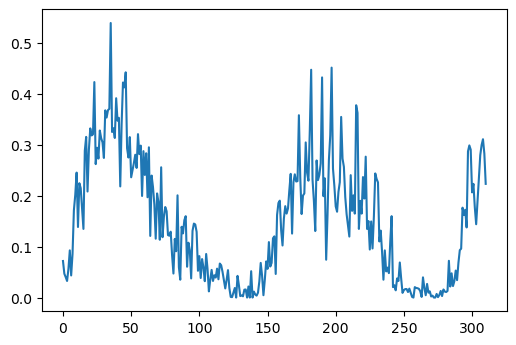

In [5]:
x = np.loadtxt('sun_spot_input.asc')

x = (x-min(x))/(max(x)-min(x))
plt.figure(dpi = 100)
plt.plot(x[1700:2011])

In [6]:
states = x.reshape(1,2820)
state = x.reshape(1,2820)
TD = 6
# equalization time lag
D = 1

# dataset size
N_tr = 200
N_te = 200

# train data
X = np.zeros((N_tr, TD))
for k in range(N_tr):
    X[k, :] = states[0, k: k + TD]

# test data
X_te = np.zeros((N_te, TD))
for k in range(N_te):
    X_te[k, :] = states[0, k + N_tr: k + TD + N_tr]

# Desired signal
T = np.zeros((N_tr, 1))
for i in range(N_tr):
    T[i, 0] = state[0, -D + i]
    
# Desire signal testing
T_te = np.zeros((N_te, 1))
for i in range(N_te):
    T_te[i, 0] = state[0, -D + i + N_tr]

# Total Desired Signal
D = np.roll(x, 1)

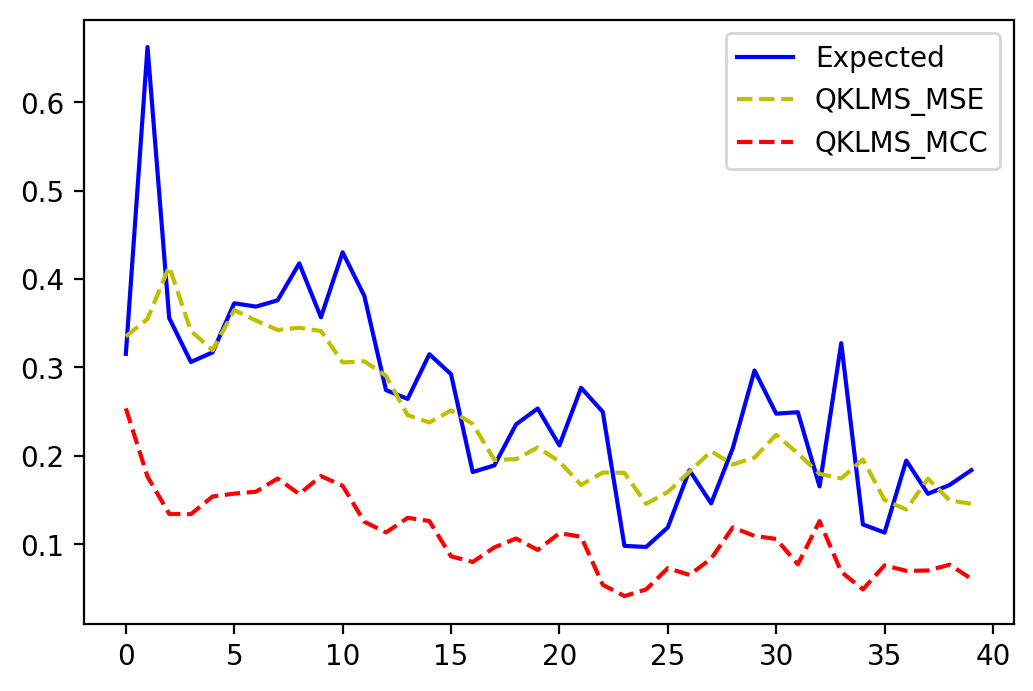

In [658]:
qkrls_MSE = QKRLS_MSE(X[0], T[0], 0.01, 0.30, 0.31)
qkrls_MCC = QKRLS_MCC(X[0], T[0], 0.01, 0.28, 1.2, 0.31)
qklms_MCC = QKLMS_MCC(TD, X[0], T[0], 0.2, 0.23, 0.8, 0.5)
qklms_MSE = QKLMS_MSE(TD, X[0], T[0], 0.2, 0.22, 0.3)
G = []
GG = []
GGG = []
GGGG = []
for i in range(N_tr):
    gg, ww = qkrls_MSE.update(X[i], T[i])
    g, w = qklms_MCC.update(X[i], T[i])
    ggg, www = qkrls_MCC.update(X[i], T[i])
    gggg, wwww = qklms_MSE.update(X[i], T[i])
    G.append(g)
    GG.append(gg)
    GGG.append(ggg)
    GGGG.append(gggg)
    
w = np.array(w)    
ww = np.array(ww)
www = np.array(www)
wwww = np.array(wwww)
Y_QKLMS_MSE = np.convolve(x, wwww.reshape(-1), mode = 'same')
Y_QKRLS_MSE = np.convolve(x, ww.reshape(-1), mode = 'same')
Y_QKLMS_MCC = np.convolve(x, w.reshape(-1), mode = 'same')
Y_QKRLS_MCC = np.convolve(x, www.reshape(-1), mode = 'same')
fig = plt.figure(dpi = 200)
# plt.plot(x[10:70], label = 'x', color='r')
plt.plot(T[10:50], label = 'Expected', color='b')


# plt.plot(Y_LMS_MSE[10:50],"--m", label = 'LMS_MSE')
# plt.plot(Y_LMS_MCC[10:50],"--c", label = 'LMS_MCC')
plt.plot(Y_QKLMS_MSE[10:50],"--y", label = 'QKLMS_MSE')
plt.plot(Y_QKLMS_MCC[10:50],"--r", label = 'QKLMS_MCC')
# plt.plot(Y_QKRLS_MSE[10:50],"--g", label = 'QKRLS_MSE')
# plt.plot(Y_QKRLS_MCC[10:50],"--k", label = 'QKRLS_MCC')

plt.legend()
# #plt.savefig('Output_MCC')

# print('Abs Err Y_QKLMS_MSE:', np.mean((D[0:200] - Y_QKLMS_MSE[0:200])**2))
# print('Abs Err Y_QKLMS_MCC:', np.mean((D[0:200] - Y_QKLMS_MCC[0:200])**2))
# print('Abs Err Y_QKRLS_MSE:', np.mean((D[0:200] - Y_QKRLS_MSE[0:200])**2))
# print('Abs Err Y_QKRLS_MCC:', np.mean((D[0:200] - Y_QKRLS_MCC[0:200])**2))
# print('Abs Err Y_LMS_MSE:', np.mean((D[0:200] - Y_LMS[0:200])**2))
# print('Abs Err Y_LMS_MCC:', np.mean((D[0:200] - Y_LMS_M[0:200])**2))

In [635]:
print('qklms_mcc', np.mean(abs(np.ravel(e))[0:200])**2)
print('qklms_mse', np.mean(abs(np.ravel(eeee))[0:200])**2)

qklms_mcc [0.00490297]
qklms_mse [0.00490297]


======ERLE======
 3.856059832718943
======Last MSE======
 0.047482328574850435
======ERLE======
 4.065294853726355
======Last MSE======
 0.04524895010542558
======ERLE======
 2.503882695184531
======Last MSE======
 0.06482607431407061
======ERLE======
 2.7675885329859877
======Last MSE======
 0.0610069255117728


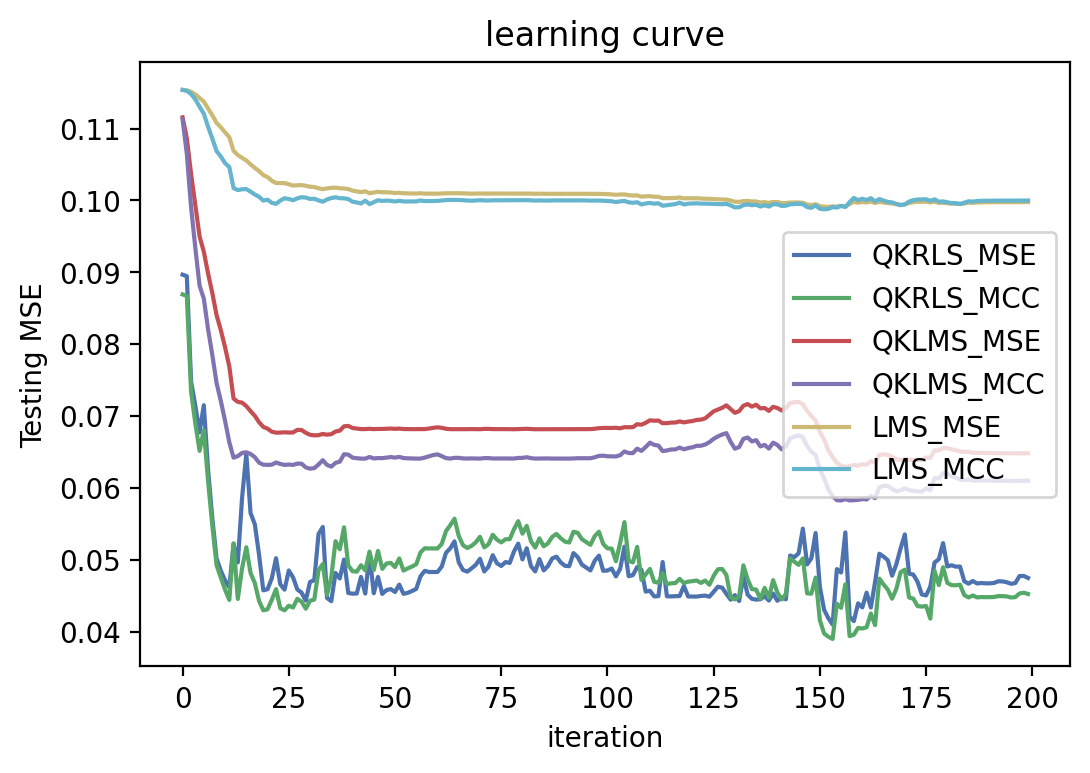

In [560]:
filters = [
#             LMS_MSE(TD, 0.1),
#             LMS_MCC(TD, 0.1, 0.7),
            QKRLS_MSE(X[0], T[0], 0.01, 0.30, 0.31),
            QKRLS_MCC(X[0], T[0], 0.01, 0.33, 1.2, 0.31),
            QKLMS_MSE(TD, X[0], T[0], 0.2, 0.22, 0.3),
            QKLMS_MCC(TD, X[0], T[0], 0.2, 0.23, 0.8, 0.3),
        ]
fig = plt.figure(dpi=200)
E = []
EE = []
for fi in filters:
    #print(f'##### Kernal-{i} | Learning Rate {k} #####', file = open('NoisyM.txt', 'a'))
    mse, ERL, err = get_training_error(fi, X, X_te, T, T_te, TD)
    E.append(mse[-1])
    EE.append(err)
    print('======ERLE======\n', ERL)
    print('======Last MSE======\n', (mse[-1]))
    #print('======Mean Error======\n', np.mean(err))
    plt.plot(mse, label=fi.name())

plt.plot(gs, label = 'LMS_MSE')
plt.plot(gss, label = 'LMS_MCC')
#plt.plot(filtro.error, label = 'LMS')
plt.legend()

plt.ylabel('Testing MSE')
plt.xlabel('iteration')
plt.title('learning curve')
plt.savefig('LC KLMS KRLS')
#plt.title(f'Learning Curve | Kernal {i} Learning Rate {k}')
#plt.savefig(f'Kernal {i} Learning Rate {k}.png')
plt.show()

In [284]:
EQKLMS=(abs(D[201:400] - Y_QKLMS_MSE[201:400]))
EQKLMSMCC=(abs(D[201:400] - Y_QKLMS_MCC[201:400]))
EQRLS=(abs(D[201:400] - Y_QKRLS_MSE[201:400]))
EQKRLSMCC=(abs(D[201:400] - Y_QKRLS_MCC[201:400]))
ELMS=(abs(D[201:400] - Y_LMS_MSE[201:400]))
ELMSMCC=(abs(D[201:400] - Y_LMS_MCC[201:400]))

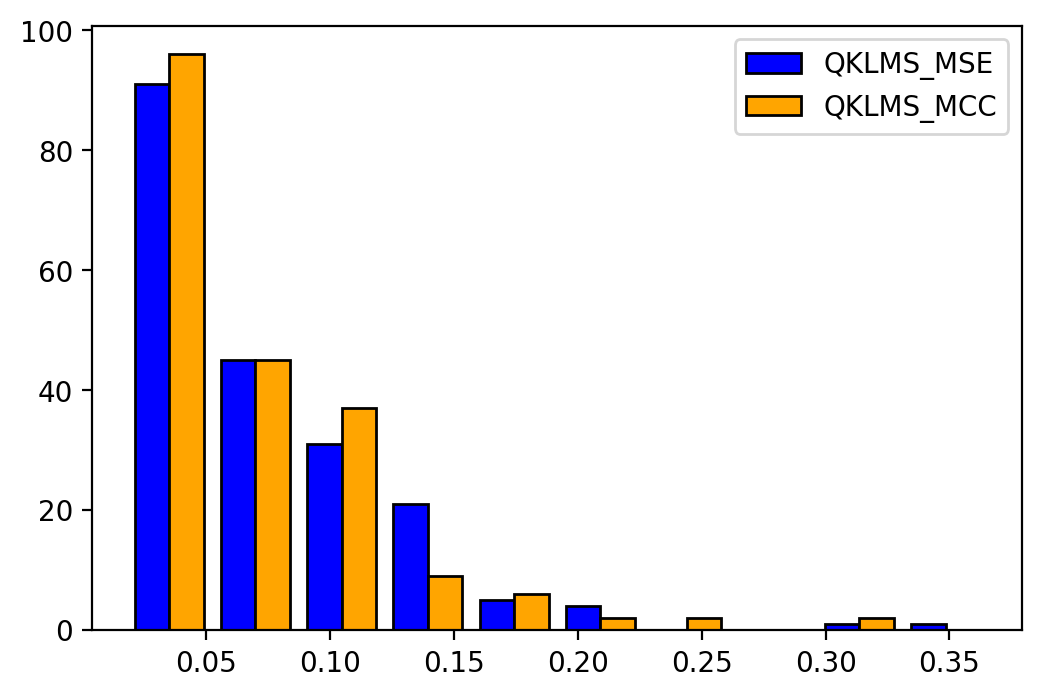

<Figure size 432x288 with 0 Axes>

In [291]:
plt.figure(dpi=200)

plt.hist([EQKLMS, EQKLMSMCC], label=['QKLMS_MSE', 'QKLMS_MCC'], align='right', color=['blue','orange'] , edgecolor='black')
plt.legend(loc='upper right')
plt.show()
plt.savefig('Hist KLMS')

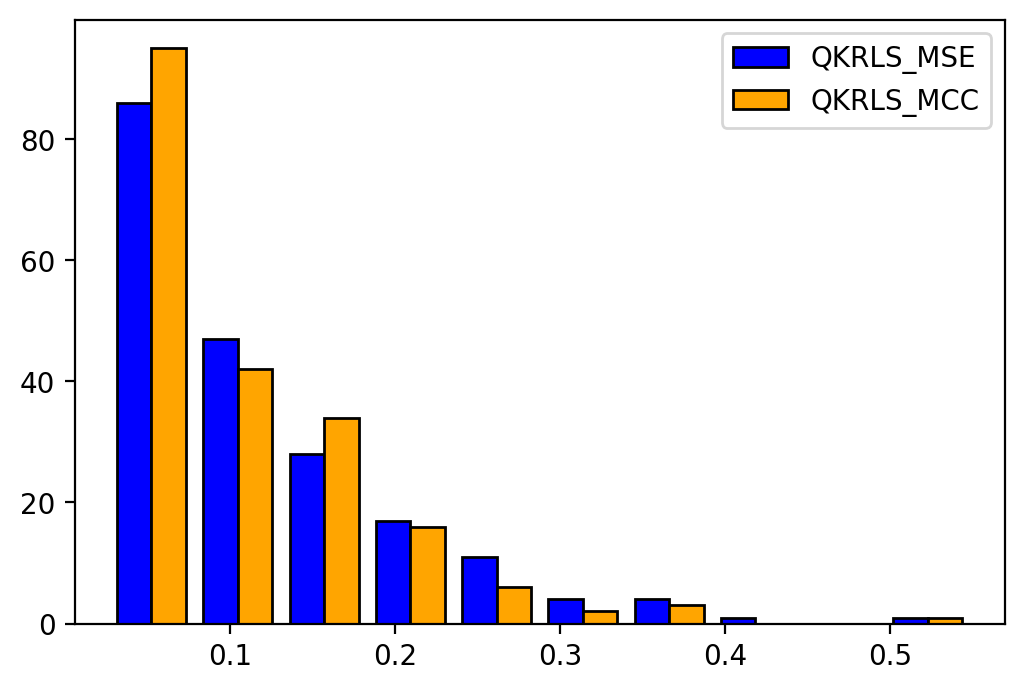

<Figure size 432x288 with 0 Axes>

In [292]:
plt.figure(dpi=200)
plt.hist([EQRLS,EQKRLSMCC], label=['QKRLS_MSE', 'QKRLS_MCC'], align='right', color=['blue','orange'] , edgecolor='black')
plt.legend(loc='upper right')
plt.show()
plt.savefig('Hist KRLS')

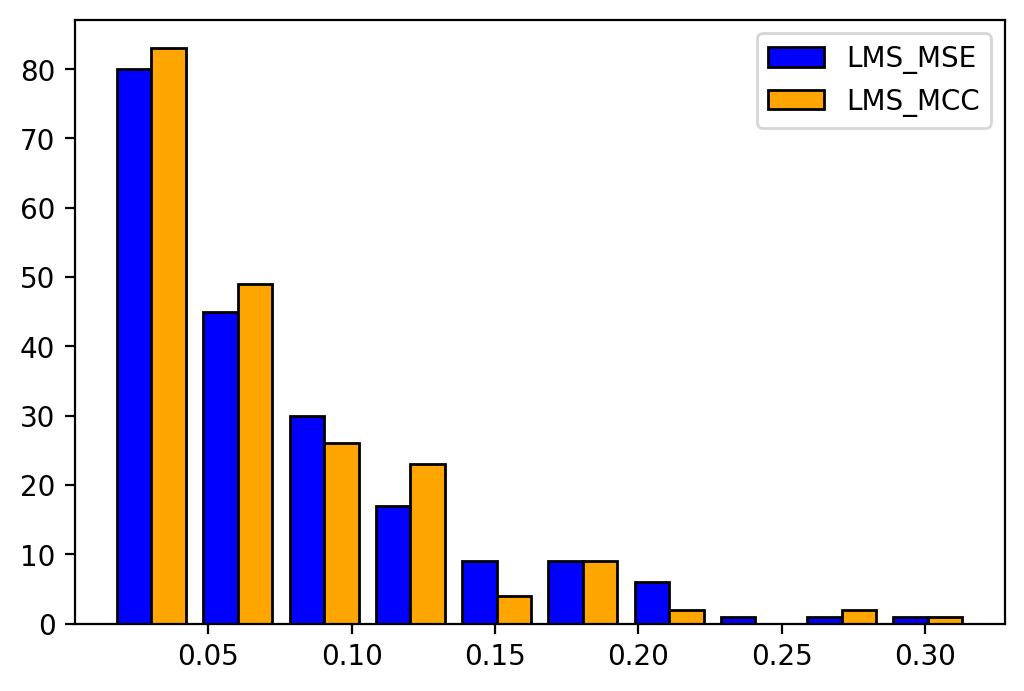

<Figure size 432x288 with 0 Axes>

In [293]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')



plt.figure(dpi=200)
plt.hist([ELMS,ELMSMCC], label=['LMS_MSE', 'LMS_MCC'], align='right', color=['blue','orange'] , edgecolor='black')
plt.legend(loc='upper right')
plt.show()
plt.savefig('Hist LMS')

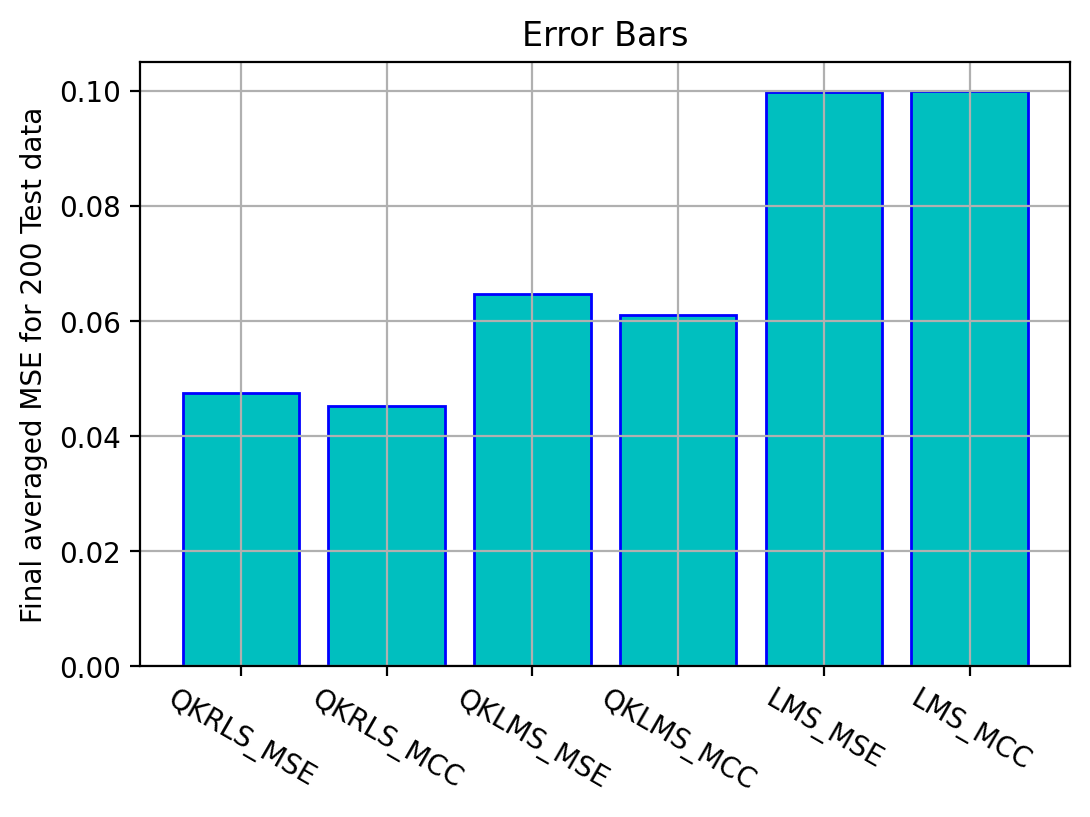

In [563]:
plt.figure(dpi = 200)
plt.bar(['QKRLS_MSE','QKRLS_MCC', 'QKLMS_MSE', 'QKLMS_MCC', 'LMS_MSE','LMS_MCC'], E, color = 'c', edgecolor = 'b')
plt.xticks(rotation = -30);
plt.ylabel('Final averaged MSE for 200 Test data' )
plt.title('Error Bars')
plt.grid()
plt.savefig('Error Bar')

In [2]:
class LMS(object):
    def __init__(self, dataset, desired, delays,
            learning_rate=.01,
            learning_rate_mu = 0,
            mu=1, w=None, b=None):
    
        if w is None:
            self.w = np.zeros((delays,1))
        else:
            self.w = w
        
        if b is None:
            self.b = 0.
        else:
            self.b = b

        self.dataset = dataset
        self.desired = desired
        self.delays = delays
        self.mu = mu
        self.learning_rate = learning_rate
        self.learning_rate_mu = learning_rate_mu

        self.prev_x = 0.
        self.error = np.asarray([])
        self.y = np.zeros_like(desired)
        self.w_track = np.zeros((delays, 1))
        self.alpha = np.zeros((self.delays,1))
        self.Xf =  np.zeros((self.delays,1))


    def fprop(self, X):
        """
        Forward propagte the input
        """

        y = np.dot(X.transpose(), self.w) #+ self.b

        return y

    def get_next_X(self, sample):
        """
        Get an input delay line
        """
        
        X  = np.zeros((self.delays,1))
        # TODO: Make the Gamma Filter work and delete this
        if self.learning_rate_mu==0.: #Just simple working solution for the regular delays
            for i in range(self.delays):
                i_sample = sample - i
                if i_sample>=0:
                    self.Xf[i] = self.dataset[i_sample]
                else:
                    self.Xf[i] = 0
        else:
            for i in range(self.delays-1,0,-1):
                if sample-i>=0:
                    self.Xf[i] = (1-self.mu)*self.Xf[i]
                    for j in range(1,i):
                        self.Xf[i] = self.Xf[i] + (1-self.mu)*(self.mu**(i-j))*self.Xf[j]
                    self.Xf[i] = self.Xf[i] + self.dataset[sample-i]

            #assert self.delays == 3
            #if sample-2 >= 0:
            #    self.Xf[2] = (1-self.mu)*self.Xf[2] + self.mu*(1-self.mu)*self.Xf[1] + self.mu**2 * self.dataset[sample-2]
            #    self.Xf[1] = (1-self.mu)*self.Xf[1] + self.mu*self.dataset[sample-1]
                else:
                    self.Xf[i] = (1-self.mu)*self.Xf[i]
            self.Xf[0] = self.dataset[sample]

        d = self.desired[sample]

        return d

    def sgd(self, sample):
        
        assert self.Xf.shape[0]==self.delays

        d = self.get_next_X(sample)
        y = self.fprop(self.Xf)
        e = d-y
        self.y = np.append(self.y, y)
        self.error = np.append(self.error, e**2)

        self.w_track = np.hstack( [self.w_track, self.w] )
        self.w = self.w + self.learning_rate*e*self.Xf
        #self.b = self.b + self.learning_rate*e
        
        for i in range(1,self.delays):
            self.alpha[i] = (1-self.mu)*self.alpha[i-1] + \
            self.mu*self.alpha[i-1] + self.Xf[i-1] - self.Xf[i]

        self.mu = self.mu + self.learning_rate_mu * e * \
                np.dot(self.alpha.transpose(), self.w)
        
        #if self.mu > 2 or self.mu<0:
        #    self.mu = np.mod(self.mu, 2)
        if self.mu > 2:
            self.mu = 2.
        if self.mu < 0:
            self.mu = 0.

    def train_lms(self, T_te, N_te, x):
        mse = []
        for i in range(len(self.dataset)):
            errors = []
            for j in range(N_te):
                errors.append(T_te[j] - self.fprop(x[j]))
            errors = np.array(errors)
            mse.append(np.mean(errors ** 2))
            #if np.mod(i,1000)==0:
                #print i
                #gc.collect()
            self.sgd(i)
        return mse

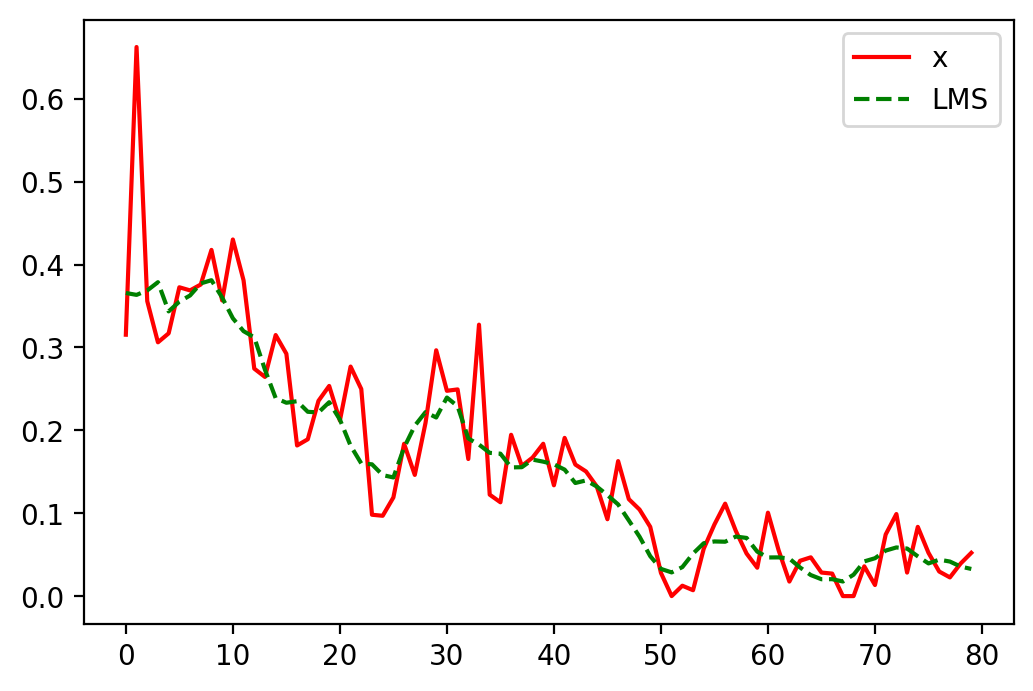

In [8]:
filtro = LMS(x[0:200], T, 6, learning_rate=0.1,
         learning_rate_mu=.0)
gs = filtro.train_lms(T_te, N_te, x)
Y_LMS = np.convolve(x, filtro.w.reshape(-1), mode = 'same')
fig = plt.figure(dpi = 200)
plt.plot(T[10:90], label = 'x', color='r')
plt.plot(Y_LMS[10:90],"--g", label = 'LMS')
plt.legend()

In [520]:
class LMS_M(object):
    def __init__(self, dataset, desired, delays,
            learning_rate=.01,
            learning_rate_mu = 0,
            correntropy_sigma = 1,
            mu=1, w=None, b=None):
    
        if w is None:
            self.w = np.zeros((delays,1))
        else:
            self.w = w
        
        if b is None:
            self.b = 0.
        else:
            self.b = b

        self.dataset = dataset
        self.desired = desired
        self.delays = delays
        self.mu = mu
        self.learning_rate = learning_rate
        self.learning_rate_mu = learning_rate_mu
        self.correntropy_sigma = correntropy_sigma
        self.prev_x = 0.
        self.error = np.asarray([])
        self.y = np.zeros_like(desired)
        self.w_track = np.zeros((delays, 1))
        self.alpha = np.zeros((self.delays,1))
        self.Xf =  np.zeros((self.delays,1))


    def fprop(self, X):
        """
        Forward propagte the input
        """

        y = np.dot(X.transpose(), self.w) #+ self.b

        return y

    def get_next_X(self, sample):
        """
        Get an input delay line
        """
        
        X  = np.zeros((self.delays,1))
        # TODO: Make the Gamma Filter work and delete this
        if self.learning_rate_mu==0.: #Just simple working solution for the regular delays
            for i in range(self.delays):
                i_sample = sample - i
                if i_sample>=0:
                    self.Xf[i] = self.dataset[i_sample]
                else:
                    self.Xf[i] = 0
        else:
            for i in range(self.delays-1,0,-1):
                if sample-i>=0:
                    self.Xf[i] = (1-self.mu)*self.Xf[i]
                    for j in range(1,i):
                        self.Xf[i] = self.Xf[i] + (1-self.mu)*(self.mu**(i-j))*self.Xf[j]
                    self.Xf[i] = self.Xf[i] + self.dataset[sample-i]

            #assert self.delays == 3
            #if sample-2 >= 0:
            #    self.Xf[2] = (1-self.mu)*self.Xf[2] + self.mu*(1-self.mu)*self.Xf[1] + self.mu**2 * self.dataset[sample-2]
            #    self.Xf[1] = (1-self.mu)*self.Xf[1] + self.mu*self.dataset[sample-1]
                else:
                    self.Xf[i] = (1-self.mu)*self.Xf[i]
            self.Xf[0] = self.dataset[sample]

        d = self.desired[sample]

        return d

    def sgd(self, sample):
        
        assert self.Xf.shape[0]==self.delays

        d = self.get_next_X(sample)
        y = self.fprop(self.Xf)
        e = d-y
        self.y = np.append(self.y, y)
        self.error = np.append(self.error, e**2)
        en = e * 1/(self.correntropy_sigma**2) * np.exp(-((e * e)/2 * self.correntropy_sigma ** 2))
        self.w_track = np.hstack( [self.w_track, self.w] )
        self.w = self.w + self.learning_rate*en*self.Xf
        #self.b = self.b + self.learning_rate*e
        
        for i in range(1,self.delays):
            self.alpha[i] = (1-self.mu)*self.alpha[i-1] + \
            self.mu*self.alpha[i-1] + self.Xf[i-1] - self.Xf[i]

        self.mu = self.mu + self.learning_rate_mu * e * \
                np.dot(self.alpha.transpose(), self.w)
        
        #if self.mu > 2 or self.mu<0:
        #    self.mu = np.mod(self.mu, 2)
        if self.mu > 2:
            self.mu = 2.
        if self.mu < 0:
            self.mu = 0.

    def train_lms(self, T_te, N_te, x):
        mse = []
        for i in range(len(self.dataset)):
            errors = []
            for j in range(N_te):
                errors.append(T_te[j] - self.fprop(x[j]))
            errors = np.array(errors)
            mse.append(np.mean(errors ** 2))
            #if np.mod(i,1000)==0:
                #print i
                #gc.collect()
            self.sgd(i)
        return mse

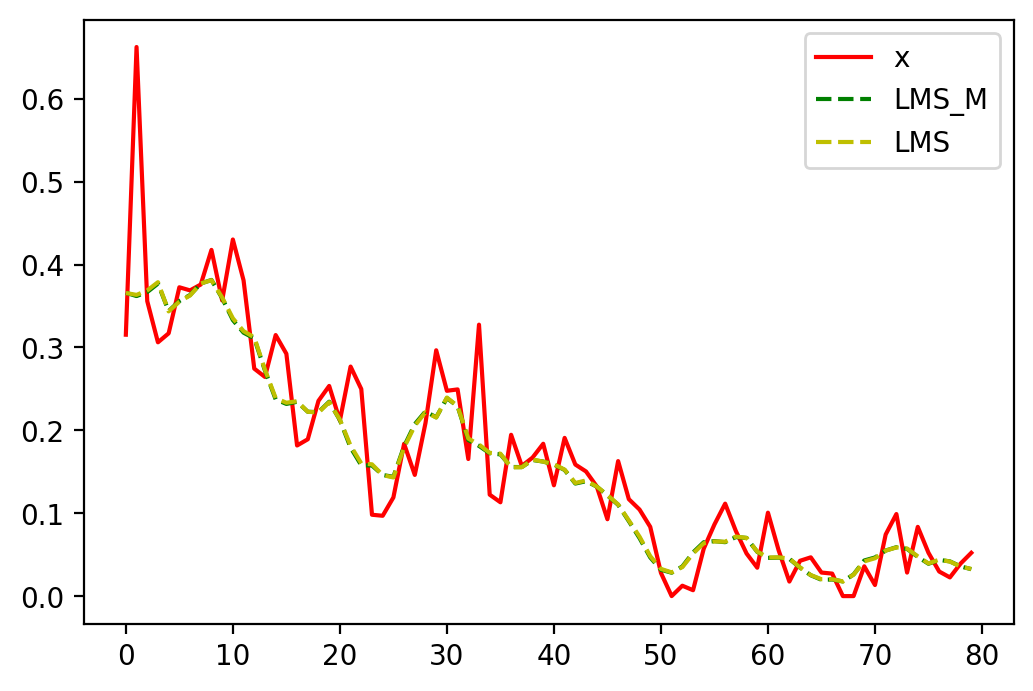

In [644]:
filtr = LMS_M(x[0:200], T, 6, learning_rate=0.1, 
         learning_rate_mu=.0, correntropy_sigma = 0.9)
gss = filtr.train_lms(T_te, N_te, x)
Y_LMS_M = np.convolve(x, filtr.w.reshape(-1), mode = 'same')
fig = plt.figure(dpi = 200)
plt.plot(T[10:90], label = 'x', color='r')
plt.plot(Y_LMS_M[10:90],"--g", label = 'LMS_M')
plt.plot(Y_LMS[10:90],"--y", label = 'LMS')
plt.legend()

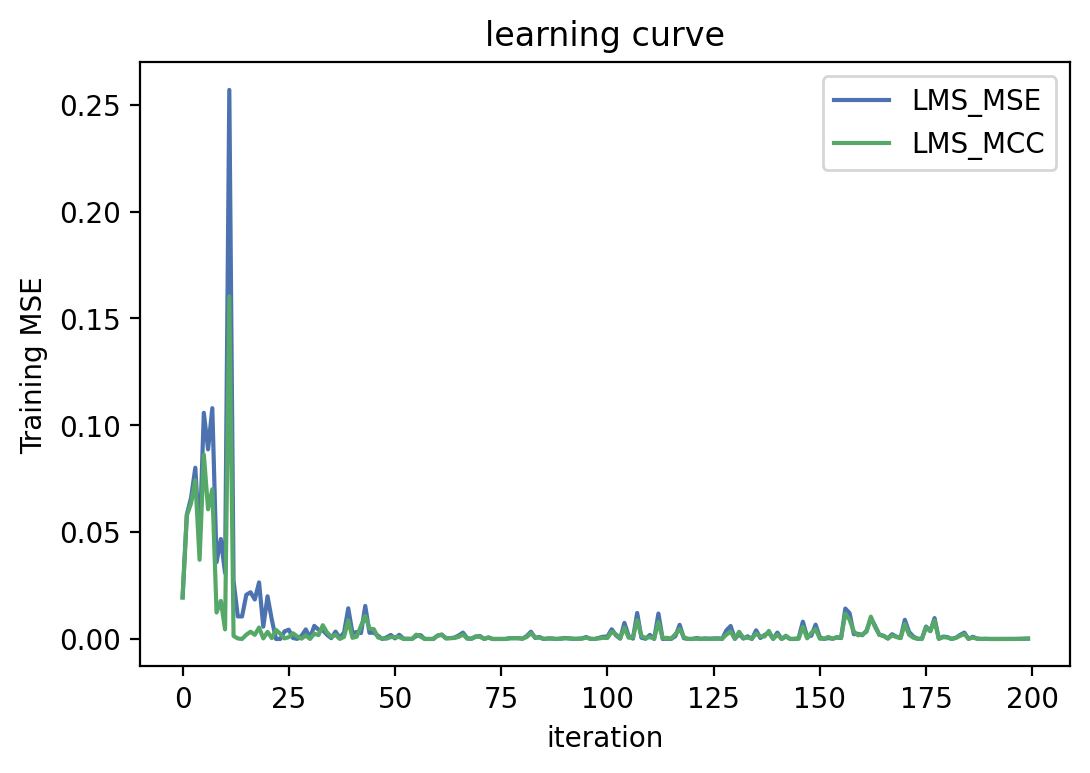

In [559]:
plt.figure(dpi=200)
plt.plot(filtro.error, label = 'LMS_MSE')
plt.plot(filtr.error, label = 'LMS_MCC')
plt.ylabel('Training MSE')
plt.xlabel('iteration')
plt.title('learning curve')


plt.legend()

[0.047482328574850435, 0.04524895010542558, 0.06482607431407061, 0.0610069255117728, 0.09978110765303855, 0.0999999644574002]


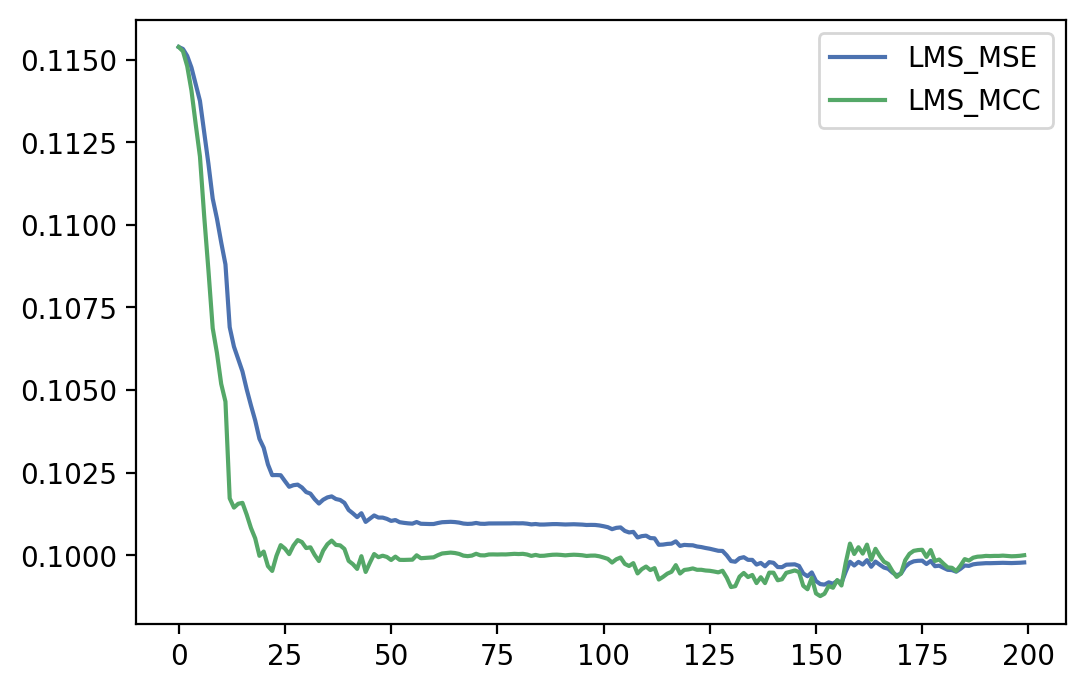

In [561]:
plt.figure(dpi = 200)
plt.plot(gs, label = 'LMS_MSE')
plt.plot(gss, label = 'LMS_MCC')

plt.legend()

E.append(gs[-1])
E.append(gss[-1])
print(E)

Abs Err Y_LMS_MSE: 0.03770752838004189
Abs Err Y_LMS_MCC: 0.04696689764635092


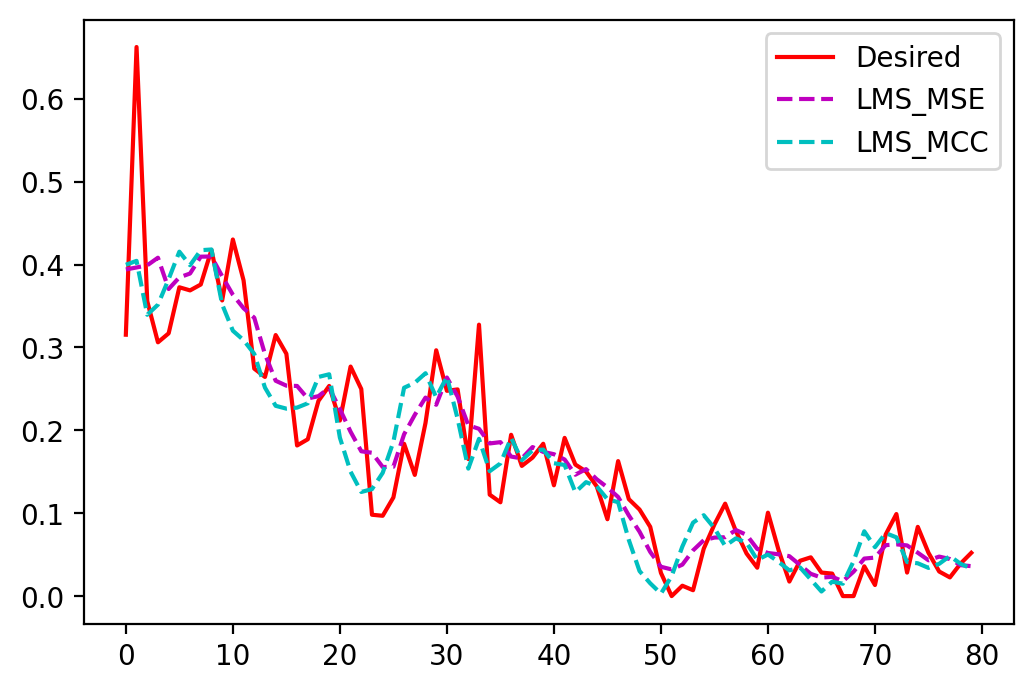

In [491]:
lms_MSE = LMS_MSE(TD, 0.1)
lms_MCC = LMS_MCC(TD, 0.1, 0.2)
for i in range(N_tr):
    ww = lms_MSE.update(X[i], T[i])
    w = lms_MCC.update(X[i], T[i])
ww = np.array(ww)
w = np.array(w)
Y_LMS_MCC = np.convolve(x, w.reshape(-1), mode = 'same')
Y_LMS_MSE = np.convolve(x, ww.reshape(-1), mode = 'same')
fig = plt.figure(dpi = 200)
plt.plot(T[10:90], label = 'Desired', color='r')
plt.plot(Y_LMS_MSE[10:90],"--m", label = 'LMS_MSE')
plt.plot(Y_LMS_MCC[10:90],"--c", label = 'LMS_MCC')
print('Abs Err Y_LMS_MSE:', np.mean(abs(D - Y_LMS_MSE)))
print('Abs Err Y_LMS_MCC:', np.mean(abs(D - Y_LMS_MCC)))
plt.legend()

{71: 29, 72: 28, 73: 27, 74: 26, 75: 25, 76: 24, 77: 23, 78: 22, 79: 21, 80: 20, 57: 19, 81: 19, 58: 18, 82: 18, 83: 17, 60: 16, 84: 16, 85: 15, 61: 15, 86: 14}
20


<ipython-input-444-b4b65a2cb263>:90: RuntimeWarning: Mean of empty slice
  v=np.nanmean(np.where(S!=99,S,np.nan),0)


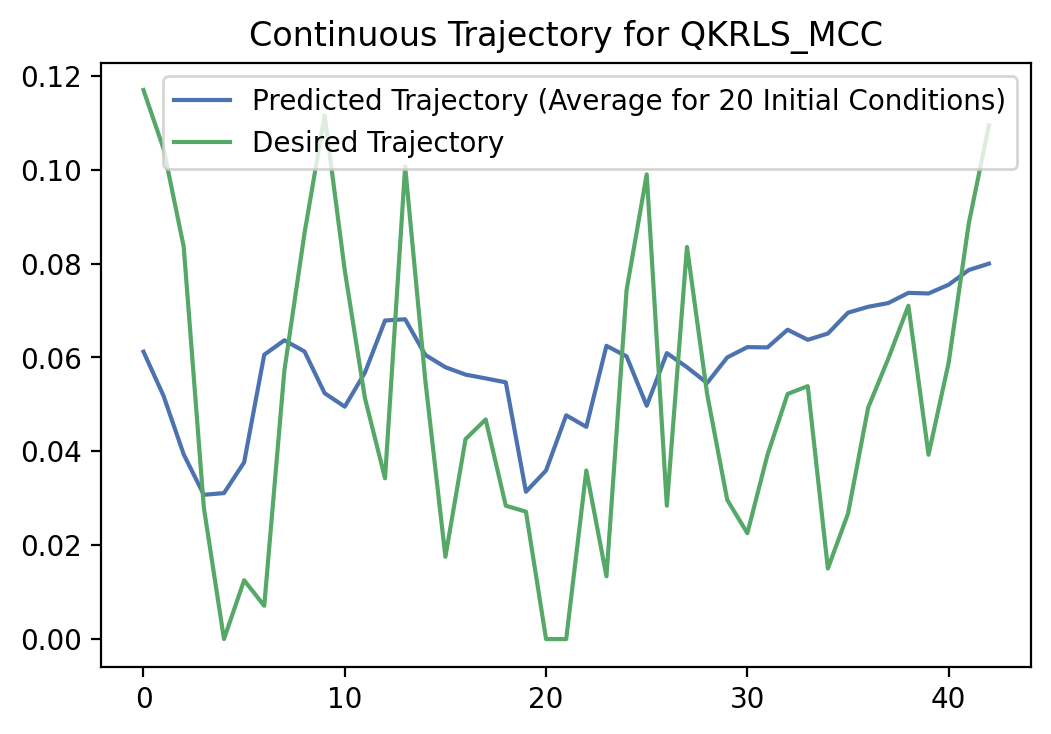

In [444]:
# Part 2

qkrls_MSE = QKRLS_MSE(X[0], T[0], 0.01, 0.1, 0.31)
qkrls_MCC = QKRLS_MCC(X[0], T[0], 0.01, 0.1, 3, 0.1)
qklms_MCC = QKLMS_MCC(TD, X[0], T[0], 0.2, 0.23, 0.8, 0.3)
qklms_MSE = QKLMS_MSE(TD, X[0], T[0], 0.2, 0.22, 0.3)
lms_MSE = LMS_MSE(TD, 0.1)
lms_MCC = LMS_MCC(TD, 0.1, 0.9)

for i in range(N_tr):
    gg, ww = qkrls_MSE.update(X[i], T[i])
    g, w = qklms_MCC.update(X[i], T[i])
    ggg, www = qkrls_MCC.update(X[i], T[i])
    gggg, wwww = qklms_MSE.update(X[i], T[i])
    wwwww = lms_MSE.update(X[i], T[i])
    wwwwwww = lms_MCC.update(X[i], T[i])

filt = qkrls_MCC
C=[]
OO = []
for st in range(200):
    start = st
    z = filt.predict(X[start]) #initialization
    o = X[start].tolist()
    o.append(np.ravel(z)[0])
    count = 1
    for i in range(10000):
        new_o = filt.predict(o[-TD:]) 
        if abs(np.ravel(new_o)[0]-D[start+2+i]) < 1/3 * np.std(x): 
            o.append(np.ravel(new_o)[0])
            count+=1
        else:
            break
    C.append(count)
    
    
H=np.argsort(C)
f=H[::-1][0:20]
ff=H[::-1]
# print('Argument', ff)
CC = []
CC2 = []
dicti ={}
dicti2 = {}


for s in ff:
    dicti2.update({s:C[s]})
    CC2.append(C[s])

# print(f'Dictionary {filt.name()}',dicti2)  
dicti3 = {}
for k,v in dicti2.items():
    if k<110 and v>13:
        dicti3.update({k:v})
        
print(dicti3)

# dicti3.pop(90)
# dicti3.pop(67)
# dicti3.pop(82)
print(len(dicti3.keys()))
F = list(dicti3.keys())
# for s in f:
#     dicti.update({s:C[s]})
#     CC.append(C[s])
#print('Count', CC)
print(f'Dictionary {filt.name()}',dicti3, file = open('Cont. Dict.txt', 'a'))

#For best 20 Arguments
for st in F:
    start = st
    z = filt.predict(X[start]) #initialization
    o = X[start].tolist()
    o.append(np.ravel(z)[0])
    count = 1
    for i in range(10000):
        new_o = filt.predict(o[-TD:]) 
        if abs(np.ravel(new_o)[0]-D[start+2+i]) < 1/3 * np.std(x): 
            o.append(np.ravel(new_o)[0])
            count+=1
        else:
            break
    OO.append(o)
    
#Average trajectory    
S = 99*np.ones((20,250))
for i, k in enumerate(dicti3.keys()):
    S[i, k:k+dicti3[k]] = OO[i][6:]
v=np.nanmean(np.where(S!=99,S,np.nan),0)
plt.figure(dpi = 200)
plt.plot(v[np.min(F):np.max(F)+dicti3[np.max(F)]], label = 'Predicted Trajectory (Average for 20 Initial Conditions)')
plt.plot(D[np.min(F):np.max(F)+dicti3[np.max(F)]], label = 'Desired Trajectory')
plt.title(f'Continuous Trajectory for {filt.name()}')
plt.legend()
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        plt.savefig(f'Trajectory Cont {filt.name()}')

In [386]:
F

[67,
 68,
 69,
 70,
 76,
 77,
 79,
 80,
 81,
 82,
 60,
 83,
 112,
 84,
 113,
 63,
 114,
 85,
 78,
 115]

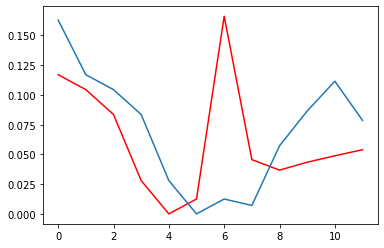

In [21]:
#Individual

start = 56
z = qkrls_MSE.predict(X[start]) #initialization
o = X[start].tolist()
o.append(np.ravel(z)[0])
count = 1
for i in range(10000):
    new_o = qklms_MSE.predict(o[-TD:]) 
    if abs(new_o[-1]-D[start+2+i]) < 1/3 * np.std(x): 
        o.append(np.ravel(new_o)[0])
        count+=1
    else:
        break
plt.plot(o, color = 'r')
plt.plot(D[start:start + 6 + count])


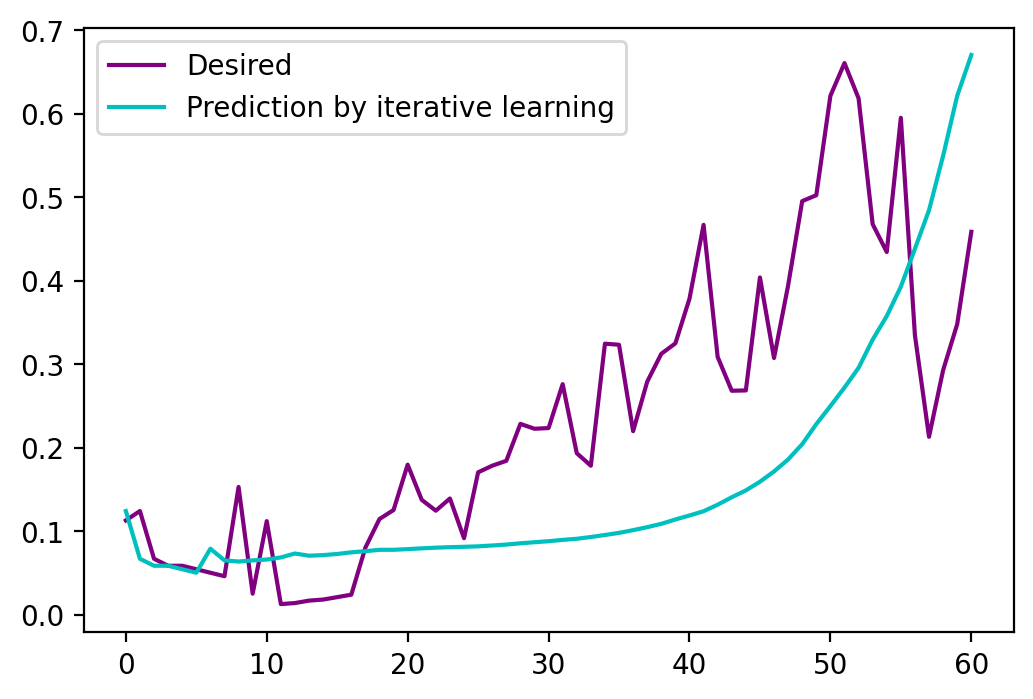

In [600]:
#Extra Creds
qkrls_MSE = QKRLS_MSE(X[0], T[0], 0.01, 0.1, 0.31)
qkrls_MCC = QKRLS_MCC(X[0], T[0], 0.01, 0.1, 3, 0.1)
qklms_MCC = QKLMS_MCC(TD, X[0], T[0], 0.2, 0.23, 0.8, 0.3)
qklms_MSE = QKLMS_MSE(TD, X[0], T[0], 0.2, 0.22, 0.3)
lms_MSE = LMS_MSE(TD, 0.1)
lms_MCC = LMS_MCC(TD, 0.1, 0.7)

for i in range(N_tr):
    gg, ww = qkrls_MSE.update(X[i], T[i])
    g, w = qklms_MCC.update(X[i], T[i])
    ggg, www = qkrls_MCC.update(X[i], T[i])
    gggg, wwww = qklms_MSE.update(X[i], T[i])
    wwwww = lms_MSE.update(X[i], T[i])
    wwwwwww = lms_MCC.update(X[i], T[i])


filt = lms_MCC
start = 199
z = filt.predict(X[start]) #initialization

o = X[start].tolist()
o.append(np.ravel(z)[0])
count = 1
for i in range(10000):
    new_o = filt.predict(o[-TD:])

#    if abs(new_o[-1]-D[start+2+i])/ 0.379551344137399 < 0.3:
    if abs(np.ravel(new_o)[0] - DD[start+2+i]) < 0.3:    
        o.append(np.ravel(new_o)[0])
        filt.update(np.array(o[-TD:]), np.array(DD[start+i]))
        count+=1
    else:
        break
plt.figure(dpi = 200)    

plt.plot(DD[start:start+len(o)],'purple', label= 'Desired' )
plt.plot(o, 'c', label ='Prediction by iterative learning')
print(f' Count for {filt.name()}:', count, file = open('Count_Extra.txt', 'a'))
plt.legend()
plt.savefig(f'Extra Cred Traj {filt.name()}')

In [122]:
qkrls_MCC = QKRLS_MCC(X[0], T[0], 0.01, 0.33, 1.1, 0.31)
for i in range(N_tr):
    g, w = qkrls_MCC.update(X[i], T[i])
w = np.array(w)
Y_QKRLS_MCC = np.convolve(x, w.reshape(-1), mode = 'same')
max(abs(D - Y_QKRLS_MCC))-min(abs(D - Y_QKRLS_MCC))

0.37973197229013134

In [579]:
D[start+2+i]

TypeError: 'int' object is not subscriptable

In [601]:
states = x.reshape(1,2820)
state = x.reshape(1,2820)
TD = 6
# equalization time lag
D = 1

# dataset size
N_tr = 500
N_te = 500

# train data
X = np.zeros((N_tr, TD))
for k in range(N_tr):
    X[k, :] = states[0, k: k + TD]

# test data
X_te = np.zeros((N_te, TD))
for k in range(N_te):
    X_te[k, :] = states[0, k + N_tr: k + TD + N_tr]

# Desired signal
T = np.zeros((N_tr, 1))
for i in range(N_tr):
    T[i, 0] = state[0, -D + i]
    
# Desire signal testing
T_te = np.zeros((N_te, 1))
for i in range(N_te):
    T_te[i, 0] = state[0, -D + i + N_tr]

filters = {
   'LMS_MSE': lms_MSE,
    'LMS_MCC': lms_MCC,
    'QKLMS_MSE': qklms_MSE,
    'QKLMS_MCC': qklms_MCC,
    'QKRLS_MSE': qkrls_MSE,
    'QKRLS_MCC': qkrls_MCC,
}
E1=[]
E2 = []
E3 = []
E4 = []
E5 = []
E6 = []
start = 200
for filt in filters.keys():
    print(filt)
    z1 = np.ravel(filters[filt].predict(X[start+1]))[0]
    err1 = abs(T[start+1] - z1)
    z10 = np.ravel(filters[filt].predict(X[start+10]))[0]
    err10 = abs(T[start+10] - z10)
    z20 = np.ravel(filters[filt].predict(X[start+20]))[0]
    err20 = abs(T[start+20] - z20)
    z50 = np.ravel(filters[filt].predict(X[start+50]))[0]
    err50 = abs(T[start+50] - z50)
    z100 = np.ravel(filters[filt].predict(X[start+100]))[0]
    err100 = abs(T[start+100] - z100)
    z101 = np.ravel(filters[filt].predict(X[start+101]))[0]
    err101 = abs(T[start+1] - z101)
    z110 = np.ravel(filters[filt].predict(X[start+110]))[0]
    err110 = abs(T[start+110] - z110)
    z120 = np.ravel(filters[filt].predict(X[start+120]))[0]
    err120 = abs(T[start+120] - z120)
    z150 = np.ravel(filters[filt].predict(X[start+150]))[0]
    err150 = abs(T[start+150] - z150)
    z200 = np.ravel(filters[filt].predict(X[start+200]))[0]
    err200 = abs(T[start+200] - z200)
    if filt == 'LMS_MSE':
        E1.extend([err1, err10, err20])
    if filt == 'LMS_MCC':
        E2.extend([err1, err10, err20])
    if filt == 'QKLMS_MSE':
        E3.extend([err1, err10, err20])
    if filt == 'QKLMS_MCC':
        E4.extend([err1, err10, err20])
    if filt == 'QKRLS_MSE':
        E5.extend([err1, err10, err20])
    if filt == 'QKRLS_MCC':
        E6.extend([err1, err10, err20])
    print("error 1: ", err1)
    print("error 10: ", err10)
    print("error 20: ", err20)
    print("error 50: ", err50)
    print("error 100: ", err100)
    print("error 101: ", err101)
    print("error 110: ", err110)
    print("error 120: ", err120)
    print("error 150: ", err150)
    print("error 200: ", err200)

LMS_MSE
error 1:  [0.00403563]
error 10:  [0.01528194]
error 20:  [0.01432405]
error 50:  [0.17444673]
error 100:  [0.03677501]
error 101:  [0.13623996]
error 110:  [0.0151663]
error 120:  [0.01111126]
error 150:  [0.26038851]
error 200:  [0.00324176]
LMS_MCC
error 1:  [0.01884446]
error 10:  [0.02062355]
error 20:  [0.04639655]
error 50:  [0.06216837]
error 100:  [0.08585825]
error 101:  [0.18426693]
error 110:  [0.00483283]
error 120:  [0.01974142]
error 150:  [0.41643388]
error 200:  [0.04335123]
QKLMS_MSE
error 1:  [0.01602469]
error 10:  [0.01789816]
error 20:  [0.00491537]
error 50:  [0.57002708]
error 100:  [0.08849122]
error 101:  [0.21432943]
error 110:  [0.01500954]
error 120:  [0.00723637]
error 150:  [0.4560645]
error 200:  [0.06366374]
QKLMS_MCC
error 1:  [0.01565079]
error 10:  [0.0124564]
error 20:  [0.00459442]
error 50:  [0.53427173]
error 100:  [0.09296631]
error 101:  [0.24401355]
error 110:  [0.02103433]
error 120:  [0.0043877]
error 150:  [0.45549729]
error 200:  [

In [149]:
def ERLE_(d, y_pred):
    d=d.reshape(-1)
    ERLE = 10 * np.log10(np.mean(d**2)/np.mean(((d-y_pred)**2)))
    return ERLE

print(ERLE_(D, Y_LMS_MSE),
      ERLE_(D, Y_LMS_MCC),
      ERLE_(D, Y_QKLMS_MSE), 
      ERLE_(D, Y_QKLMS_MCC), 
      ERLE_(D, Y_QKRLS_MSE), 
      ERLE_(D, Y_QKRLS_MCC))

14.397256808590658 14.052257492947097 13.901608311515288 14.51943462871827 12.206806247506844 12.658369212047297


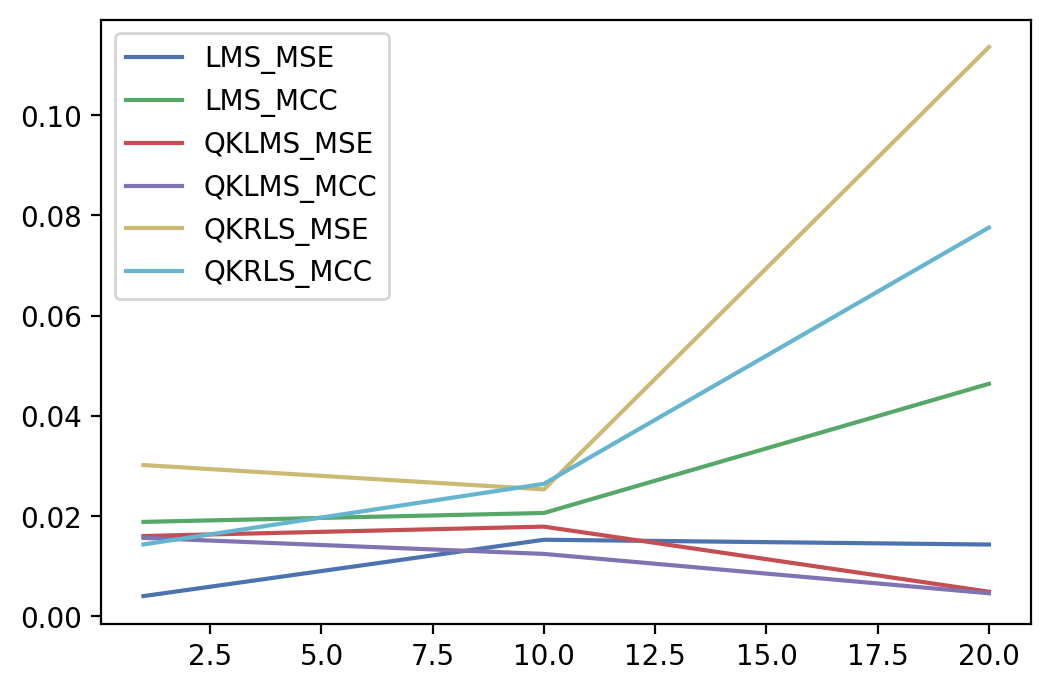

In [602]:
plt.figure(dpi = 200)
plt.plot([1,10,20], E1, label = 'LMS_MSE')
plt.plot([1,10,20],E2, label = 'LMS_MCC')
plt.plot([1,10,20],E3, label = 'QKLMS_MSE')
plt.plot([1,10,20],E4, label = 'QKLMS_MCC')
plt.plot([1,10,20],E5, label = 'QKRLS_MSE')
plt.plot([1,10,20],E6, label = 'QKRLS_MCC')
plt.xlabel('No. of Samples')

plt.legend()

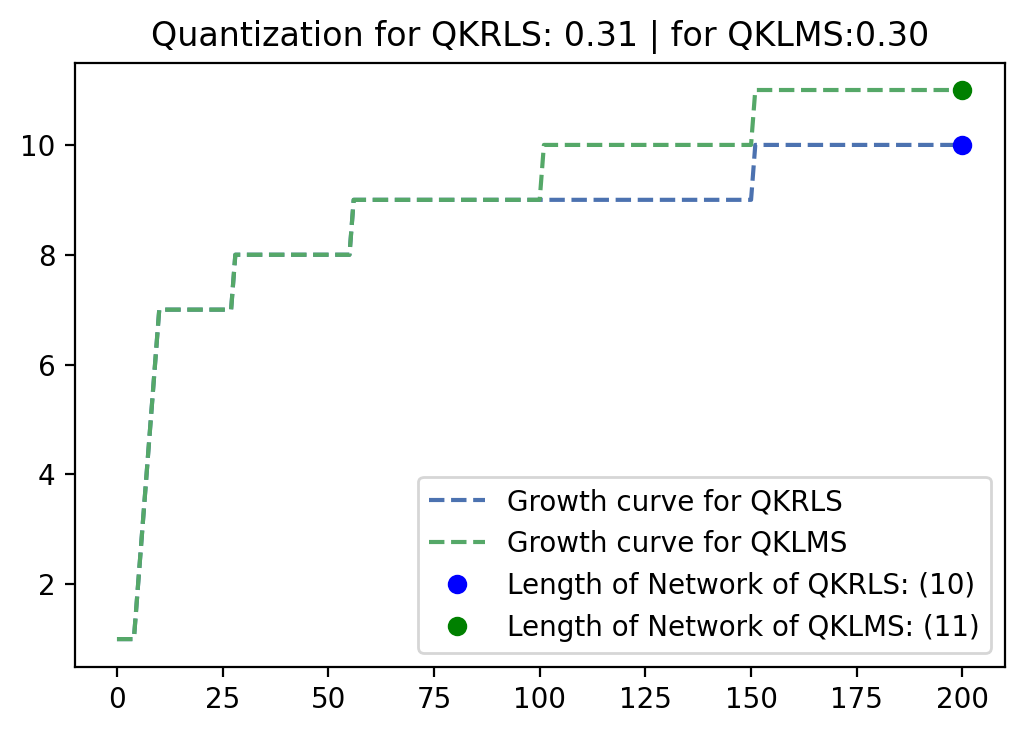

In [566]:
plt.figure(dpi = 200)
plt.plot(GG, '--', label = 'Growth curve for QKRLS')
plt.plot(G, '--',  label = 'Growth curve for QKLMS')
plt.plot(200, max(GG), 'bo', label = f'Length of Network of QKRLS: ({max(GG)})')
plt.plot(200, max(G), 'go', label = f'Length of Network of QKLMS: ({max(G)})')

plt.title('Quantization for QKRLS: 0.31 | for QKLMS:0.30' )

plt.legend()
plt.savefig('Growth Curve')

array([[0.01069694],
       [0.0128302 ],
       [0.00944765],
       [0.00862447],
       [0.00779418],
       [0.00756712]])